# SIGNAL PROCESSING TP3 - M2 AI
## To Do: noise spectrum density estimation and Wiener filtering

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

---

## IMPORT

In [4]:
import numpy as np
from PIL import Image
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal import stft, istft
from scipy.signal import periodogram, welch

In [5]:
def create_periodogram_and_welch(filename):
    """
    Estimate the spectral density of a given noise file using both the periodogram and Welch methods. 
    
    Parameters:
    - filename: Path to the noise file.
    
    Returns:
    - Slope of the PSD in the log-log scale.
    """
    noise, sample_rate = sf.read(filename)

    # Estimate the spectrum density using periodogram
    f_periodogram, p_periodogram = periodogram(noise, fs=sample_rate)

    # Estimate the spectrum density using Welch method
    f_welch, p_welch = welch(noise, fs=sample_rate, nperseg=1024)

    # Compute the slope for the Welch PSD in log-log scale
    log_freq = np.log10(f_welch[1:])   
    log_Pxx = np.log10(p_welch[1:])

    # Linear fit to find the slope and intercept
    slope, intercept = np.polyfit(log_freq, log_Pxx, 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    fig.suptitle(f'Spectrum Density of {filename}', fontsize=16, y=1.02)
    
    axs[0].semilogy(f_periodogram, p_periodogram)
    axs[0].set_title(f'Periodogram method plot')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Power/Frequency (dB/Hz)')
    axs[0].grid()
    
    axs[1].loglog(f_welch, p_welch, label="Original Data")
    axs[1].loglog(f_welch[1:], 10**(intercept + slope*log_freq), 'r--', label=f"Linear fit (Slope: {slope:.2f})")
    axs[1].set_title(f'Log-Log Welsh method plot with Linear Fit')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Power/Frequency (dB/Hz)')
    axs[1].legend()
    axs[1].grid(which='both')
    
    plt.tight_layout()
    plt.show()

    return slope

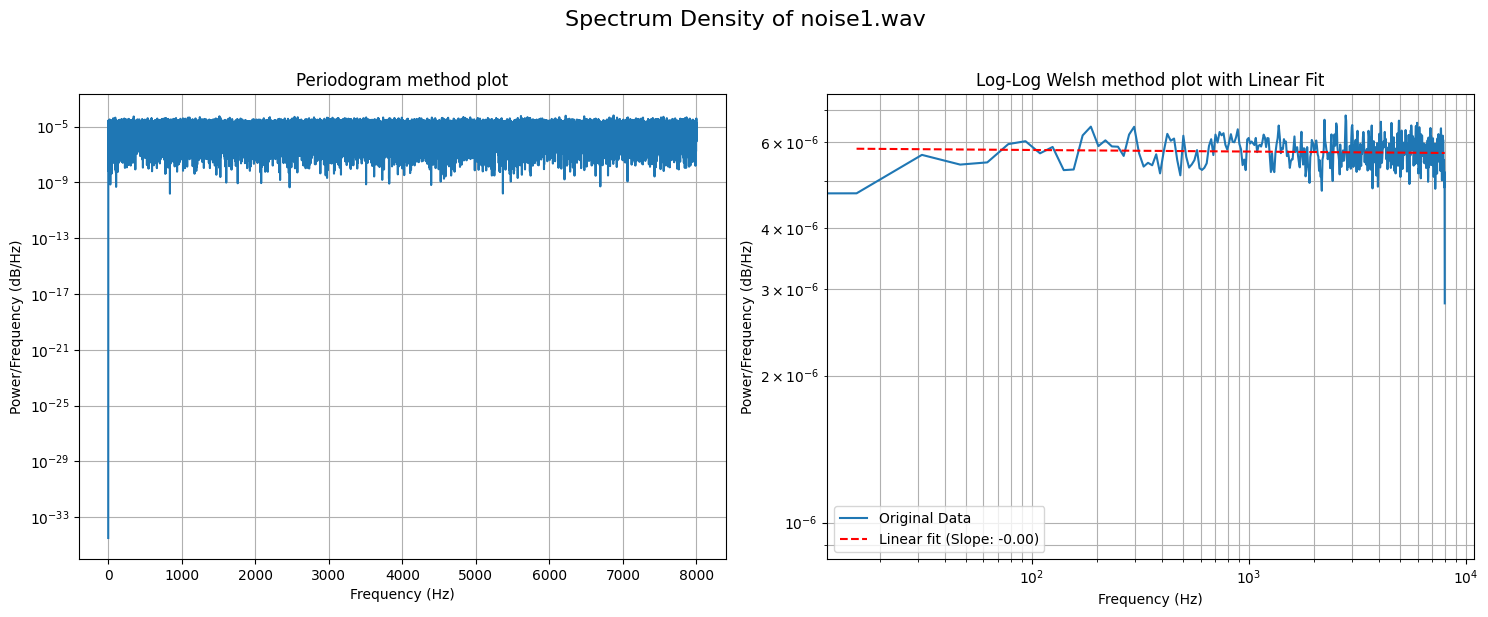

[noise1.wav] The color of the noise is White with slope of -0.003196690320716558


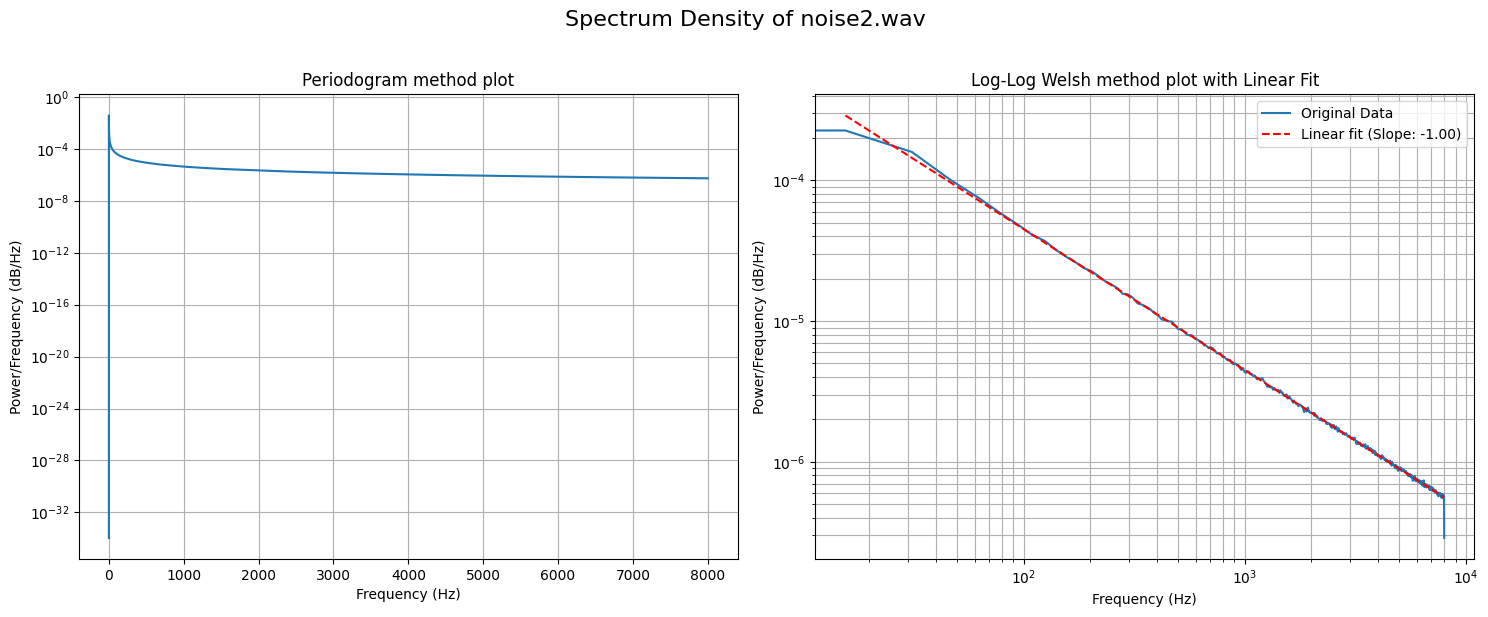

[noise2.wav] The color of the noise is Pink (or 1/f noise) with slope of -1.0017960536667927


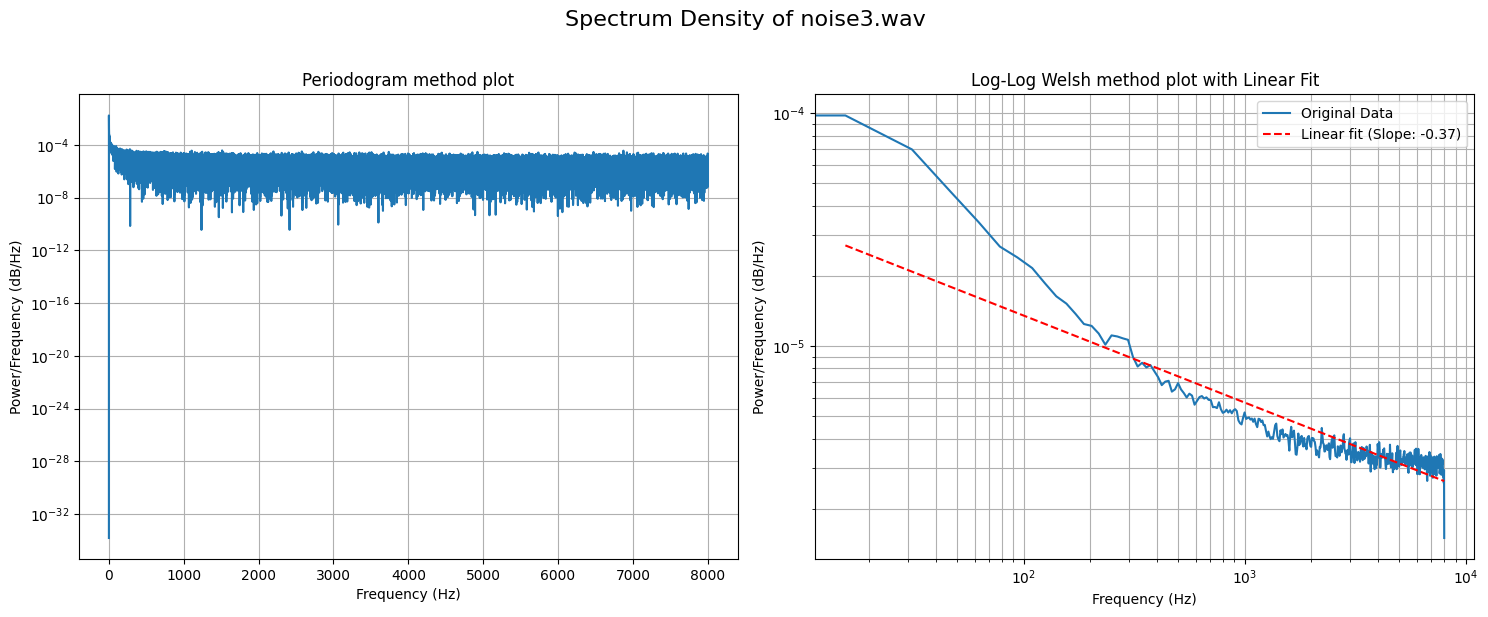

[noise3.wav] The color of the noise is White and Pink with slope of -0.37351257318087955


In [6]:
FILES = ["noise1.wav", "noise2.wav", "noise3.wav"]
ANSWERS = ["White", "Pink (or 1/f noise)", "White and Pink"]

for f,a in zip(FILES, ANSWERS):
    slope = create_periodogram_and_welch(f)
    print(f"[{f}] The color of the noise is {a} with slope of {slope}")

### Periodogram:
- The periodogram is a simple method for estimating the power spectral density (PSD) of a signal.
- While it's straightforward and easy to compute, the periodogram often suffers from high variance, meaning that its values can fluctuate significantly for different realizations of the same process.
- This variance can sometimes make it difficult to interpret the true underlying spectral content of a signal.

### Welch Method:
- The Welch method is an improved method for estimating the PSD that reduces the variance of the periodogram.
- It involves dividing the signal into overlapping segments, computing a modified periodogram for each segment, and then averaging these periodograms.
- By averaging the periodograms of multiple segments, the Welch method reduces the variance and provides a smoother and more reliable estimate of the PSD.

### Interesting finding (coincidence)
When we add the power spectrum of `noise1.wav` and `noise2.wav`, we have a slope of `-0.40` which is approximately equivalent with `noise3.wav`

---

In [64]:
def add_gaussian_noise(image, desired_snr_db):
    """
    Adds Gaussian white noise to an image to achieve a desired SNR.
    
    Parameters:
    - image: Input image (2D numpy array).
    - desired_snr_db: Desired SNR in dB.
    
    Returns:
    - Noisy image.
    """
    image_float = image.astype(np.float32)
    
    # Calculate the power of the image
    image_power = np.sum(image_float**2)
    
    # Calculate the power of the noise needed to achieve the desired SNR
    noise_power = image_power / (10**(desired_snr_db / 10))
    
    # Generate Gaussian white noise
    noise = np.random.normal(scale=np.sqrt(noise_power / np.prod(image.shape)), size=image.shape)
    
    # Add the noise to the image
    noisy_image = np.clip(image_float + noise, 0, 255).astype(np.uint8)
    
    return noisy_image

def wiener_filter(noisy, local_mean=None, noise_var=None):
    """
    Apply Wiener filter to denoise an image.
    
    Parameters:
    - noisy: Noisy image.
    - local_mean: Local mean of the noisy image. If None, it will be computed.
    - noise_var: Variance of the noise. If None, it will be computed.
    
    Returns:
    - Denoised image.
    """
    if local_mean is None:
        # Use a simple average filter for local mean
        kernel = np.ones((5, 5)) / 25
        local_mean = convolve2d(noisy, kernel, boundary='symm', mode='same')
    
    if noise_var is None:
        noise_var = np.var(noisy - local_mean)
    
    local_var = convolve2d(noisy**2, kernel, boundary='symm', mode='same') - local_mean**2
    denoised = local_mean + (local_var - noise_var) / (local_var + 1e-6) * (noisy - local_mean)
    
    return np.clip(denoised, 0, 255) 

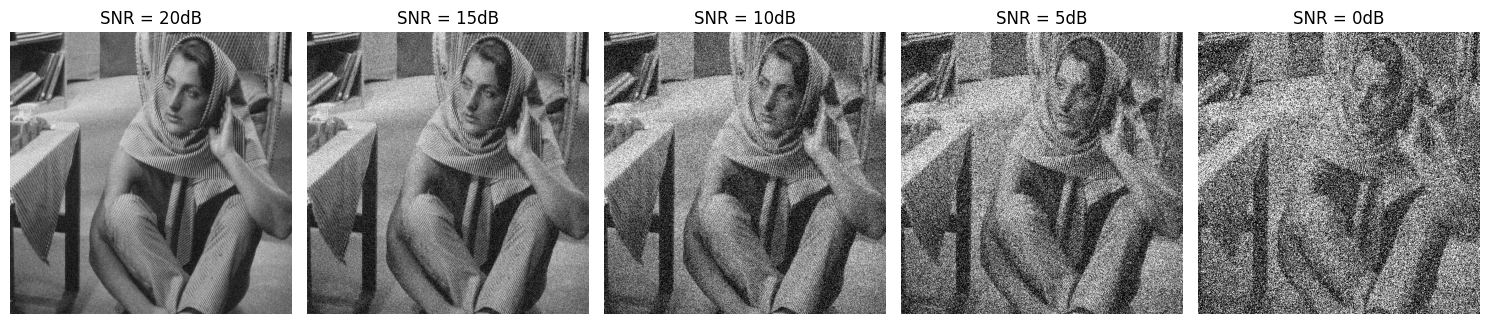

In [74]:
# List of desired SNR levels
snr_levels = [20, 15, 10, 5 , 0]
noisy_images = {}

barbara_img = Image.open('barbara.jpeg')
barbara_array = np.array(barbara_img.convert('L')) 

# Generate noisy images for each SNR level
for snr in snr_levels:
    noisy_images[snr] = add_gaussian_noise(barbara_array, snr)

# Display the noisy images
fig, axs = plt.subplots(1, len(snr_levels), figsize=(15, 15))
for ax, (snr, img) in zip(axs, noisy_images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"SNR = {snr}dB")
    ax.axis('off')

plt.tight_layout()
plt.show()


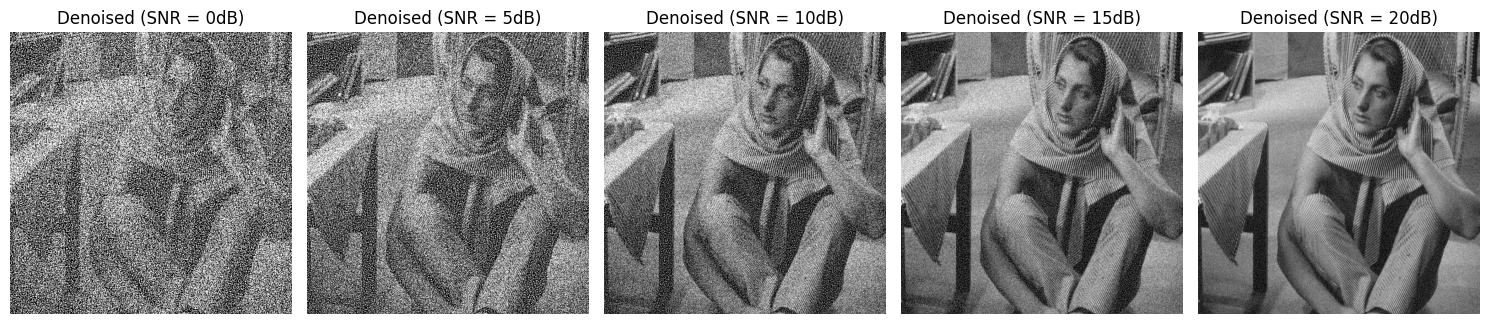

In [67]:
# Apply Wiener filter to denoise the images with different SNR levels
denoised_images = {}
for snr, noisy_img in noisy_images.items():
    denoised_images[snr] = wiener_filter(noisy_img)

fig, axs = plt.subplots(1, len(snr_levels), figsize=(15, 15))
for ax, (snr, img) in zip(axs, denoised_images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Denoised (SNR = {snr}dB)")
    ax.axis('off')
 
plt.tight_layout()
plt.show()


---

In [69]:

def oracle_wiener_denoise(noisy, clean, noise, n_fft=1024, hop_size=512):
    """
    Denoise a noisy signal using the Oracle Wiener filter.
    
    Parameters:
    - noisy: Noisy signal.
    - clean: Clean signal (original).
    - noise: Noise signal that was added to the clean signal.
    - n_fft: FFT size for STFT.
    - hop_size: Hop size for STFT.
    
    Returns:
    - Denoised signal.
    """
    # Compute the short-time Fourier transform (STFT) of the signals
    _, _, Zxx_noisy = stft(noisy, nperseg=n_fft, noverlap=n_fft - hop_size)
    _, _, Zxx_clean = stft(clean, nperseg=n_fft, noverlap=n_fft - hop_size)
    _, _, Zxx_noise = stft(noise, nperseg=n_fft, noverlap=n_fft - hop_size)
    
    # Compute the power spectral densities
    Pxx_noisy = np.abs(Zxx_noisy) ** 2
    Pxx_clean = np.abs(Zxx_clean) ** 2
    Pxx_noise = np.abs(Zxx_noise) ** 2
    
    # Oracle Wiener filter
    G = Pxx_clean / (Pxx_clean + Pxx_noise)
    
    # Apply the filter
    Zxx_denoised = G * Zxx_noisy
    
    # Compute the inverse STFT to get the denoised time-domain signal
    _, denoised = istft(Zxx_denoised, nperseg=n_fft, noverlap=n_fft - hop_size)
    
    return denoised

In [73]:
music1, sr_music = sf.read('music.wav')

# Noisy versions of the music with each noise
noisy_musics = {}
denoised_musics = {}
for i, noise_file in enumerate(['noise1.wav', 'noise2.wav', 'noise3.wav']):
    noise_data, _ = sf.read(noise_file)
    
    # Adjust the noise length to match the music length
    noise_data = np.resize(noise_data, music1.shape)
    
    # Add noise to the music with a global factor of 0.1
    noisy_music = music1 + 0.1 * noise_data
    noisy_musics[i] = noisy_music
    
    # Denoise using Oracle Wiener filter
    denoised_music = oracle_wiener_denoise(noisy_music, music1, 0.1 * noise_data)
    denoised_musics[i] = denoised_music

# Return the first few samples of the first denoised music for verification
denoised_musics[0][:10]

array([-0.00630196, -0.01000458, -0.00921996, -0.00344203,  0.00392172,
        0.00709006,  0.00169262, -0.0112363 , -0.02486938, -0.03051671])

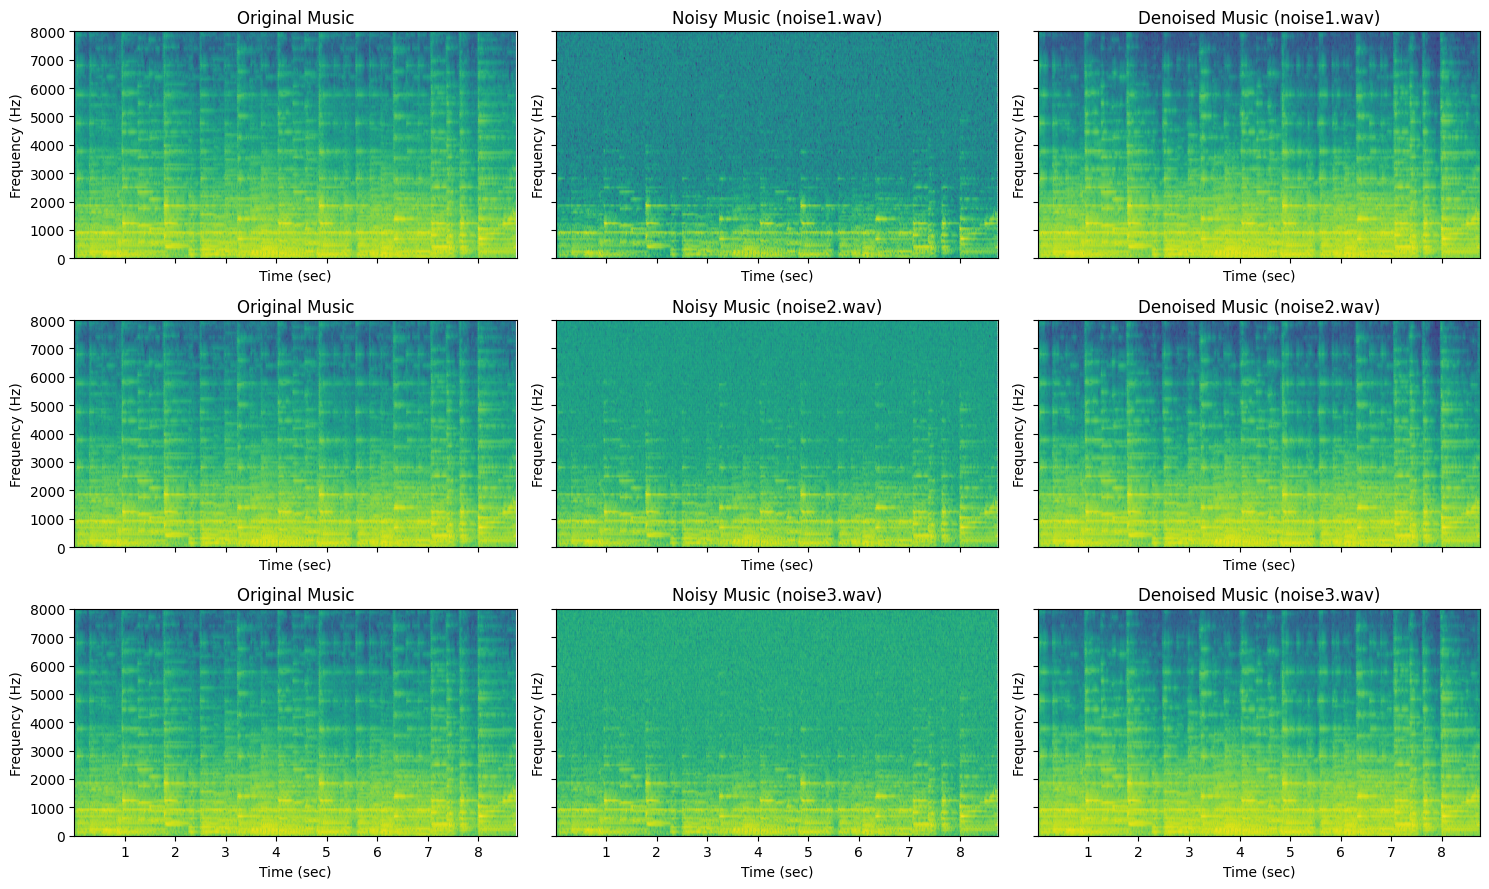

In [76]:
from scipy.signal import spectrogram

def plot_spectrogram(signal, sr, ax, title):
    """
    Plot the spectrogram of the given signal on the provided axis.
    """
    f, t, Sxx = spectrogram(signal, sr)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (sec)')
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# Spectrogram for original music
for ax in axs[:, 0]:
    plot_spectrogram(music1, sr_music, ax, "Original Music")

# Spectrogram for noisy and denoised music for each noise type
for i, (noise_name, ax_row) in enumerate(zip(['noise1.wav', 'noise2.wav', 'noise3.wav'], axs)):
    plot_spectrogram(noisy_musics[i], sr_music, ax_row[1], f"Noisy Music ({noise_name})")
    plot_spectrogram(denoised_musics[i], sr_music, ax_row[2], f"Denoised Music ({noise_name})")

plt.tight_layout()
plt.show()
